In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob


创建dataser

In [2]:
images_train = glob.glob(r'D:\model\CT_data\train\imgs\*.png')
masks_train = glob.glob(r'D:\model\CT_data\train\masks\*.png')
train_count = len(images_train)

In [3]:
index = np.random.permutation(train_count)

In [4]:
images_train = np.array(images_train)[index]
masks_train = np.array(masks_train)[index]

In [5]:
images_test = glob.glob(r'D:\model\CT_data\valid\imgs\*.png')
masks_test = glob.glob(r'D:\model\CT_data\valid\masks\*.png')
test_count = len(images_test)

In [6]:
dataset_train = tf.data.Dataset.from_tensor_slices((images_train,masks_train))

In [7]:
dataset_test = tf.data.Dataset.from_tensor_slices((images_test,masks_test))

In [8]:
def read_images_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=3)
    return img

In [9]:
def read_masks_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=1)
    return img

In [10]:
img_1 = read_images_png(images_train[0])

In [11]:
mask_1 = read_masks_png(masks_train[0])


数据增强

In [12]:
def crop_img(img,mask):
    concat_img = tf.concat([img,mask],axis = -1)
    concat_img = tf.image.resize(concat_img,(280,280),
                                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img,[256,256,4])
    return crop_img[ :, :, :3], crop_img[ :, :, 3:]

In [13]:
img_1,mask_1 = crop_img(img_1,mask_1)

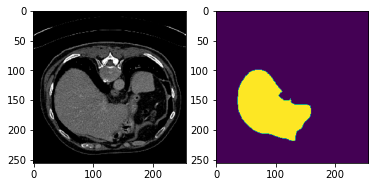

In [14]:
plt.subplot(1,2,1)
plt.imshow(img_1.numpy())
plt.subplot(1,2,2)
plt.imshow(mask_1.numpy())

In [15]:
def normal(img,mask):
    img = tf.cast(img, tf.float32)/127.5 - 1
    mask = tf.cast(mask/255, tf.int32)
    return img, mask


加载图片

In [16]:
def load_train_image(img_path,mask_path):
    img = read_images_png(img_path)
    mask = read_masks_png(mask_path)
    img,mask = crop_img(img,mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    img_f32,mask_int32 = normal(img,mask)
    return img_f32,mask_int32

In [17]:
def load_test_image(img_path,mask_path):
    img = read_images_png(img_path)
    mask = read_masks_png(mask_path)
    img = tf.image.resize(img,(256,256))
    mask = tf.image.resize(mask,(256,256))
    img_f32,mask_int32 = normal(img,mask)
    return img_f32,mask_int32

In [18]:
BATCH_SIZE = 5 
BUFFER_SIZE = 10 
step_per_epoch = train_count//BATCH_SIZE
test_step = test_count//BATCH_SIZE
auto = tf.data.experimental.AUTOTUNE

In [19]:
dataset_train = dataset_train.map(load_train_image,num_parallel_calls = auto)
dataset_test = dataset_test.map(load_test_image,num_parallel_calls = auto)

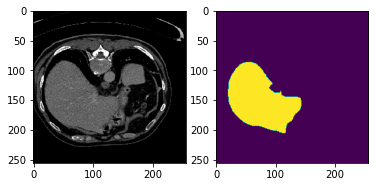

In [20]:
for i, m in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy()+1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))
    plt.imshow(m.numpy())
    

In [21]:
dataset_train = dataset_train.cache().repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(auto)
dataset_test = dataset_test.cache().batch(BATCH_SIZE)

In [32]:
dataset_train

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>

In [33]:
dataset_test

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>

u-net模型

In [22]:
class Down_sample(tf.keras.layers.Layer):
    def __int__(self,units):
        super(Down_sample,self).__int__()
        self.conv1 = tf.keras.layers.Conv2D(units,kernel_size=3,
                                            padding='same')
        self.conv2 = tf.keras.layers.Conv2D(units,kernel_size=3,
                                            padding='same')
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
    def call(self,x,is_pool=True):
        if is_pool:
            x= self.pool(x)
        x = self.conv1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        return x
    

In [23]:
class Up_sample(tf.keras.layers.Layer):
    def __int__(self,units):
        super(Up_sample,self).__int__()
        self.conv1 = tf.keras.layers.Conv2D(units,kernel_size=3,
                                            padding='same')
        self.conv2 = tf.keras.layers.Conv2D(units,kernel_size=3,
                                            padding='same')
        self.deconv = tf.keras.layers.Conv2DTranspose(units//2,
                                                    kernel_size=2,
                                                    strides=2,
                                                    padding='same')
    def call(self,x):
        x = self.conv1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.deconv(x)
        x = tf.nn.relu(x)
        return x

In [24]:
class myU_net_model(tf.keras.Model):
    def __int__(self):
        super(Unet_model,self).__init__()
        self.down_sample_I = Down_sample(64)
        self.down_sample_II = Down_sample(128)
        self.down_sample_III = Down_sample(256)
        self.down_sample_IV = Down_sample(512)
        self.down_sample_V = Down_sample(1024)
        
        self.up_sample=tf.keras.layers.Conv2DTranspose(512,
                                                kernel_size=2,
                                                strides=2,
                                                padding='same')
        
        self.up_sample_I = Up_sample(512)
        self.up_sample_II = Up_sample(256)
        self.up_sample_III = Up_sample(128)
        
        self.conv_last = Down_sample(64)
        self.last = tf.keras.layers.Conv2D(2,
                                           kernel_size=1,
                                           padding='same')
        
    def call(self,x):
        x1 = self.down_sample_I(x,is_pool=False)
        x2 = self.down_sample_II(x1)
        x3 = self.down_sample_III(x2)
        x4 = self.down_sample_IV(x3)
        x5 = self.down_sample_V(x4)
        
        x5 = self.up_sample(x5)
        
        x5 = tf.concat([x4,x5])
        x5 = self.up_sample_I(x5)
        
        x5 = tf.concat([x3,x5])
        x5 = self.up_sample_II(x5)
        
        x5 = tf.concat([x2,x5])
        x5 = self.up_sample_III(x5)
        
        x5 = tf.concat([x1,x5])
        
        x5 = self.conv_last(x5,is_pool=False)
        
        x5 = self.last(x5)
        return x5

In [25]:
model = myU_net_model()

In [26]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self,y_ture,y_pred,sample_weight=None):
        y_pred = tf.argmax(y_pred,axis=-1)
        return super().__call__(y_ture,y_pred,sample_weight=sample_weight)

训练

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [28]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')
train_iou = MeanIoU(2,name='tain_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')
test_iou = MeanIoU(2,name='test_iou')

In [29]:
@tf.function
def train_step(images,labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss(labels,predictions)
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels,predictions)
    train_iou(labels,predictions)

In [30]:
@tf.function
def test_step(images,labels):
    predictions= model(images)
    t_loss=loss_object(labels,predictions)
    test_loss(t_loss)
    
    test_accuracy(labels,predictions)
    test_iou(labels,predictions)  

In [31]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_iou.reset_states()
    
    for images,labels in dataset_train:
        train_step(images,labels)
        
    for test_images,test_labels in dataset_val:
        train_step(test_images,test_labels)
        
    template ='EPOCH {:.3f}, Loss:{:.3f}, Accuracy: {:.3f},\
               IOU:{:.3f},Test Loss:{:.3f},\
               Test Acurracy:{:.3f},Test IOU:{:.3f}'
    
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           train_iou.result(),
                           test_loss.result(),
                           test_accuracy.result()*100,
                           test_iou.result()
                         ))

AttributeError: in converted code:

    <ipython-input-29-6f876a85ec39>:4 train_step  *
        predictions = model(images)
    D:\1\envs\myproject\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:778 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    <ipython-input-24-fad454075fda>:25 call  *
        x1 = self.down_sample_I(x,is_pool=False)

    AttributeError: 'myU_net_model' object has no attribute 'down_sample_I'
